In [6]:
import pandas as pd
import numpy as np
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns; sns.set()


%matplotlib inline

# Goal: http://www.nature.com/ng/journal/v48/n5/fig_tab/ng.3547_F1.html
#http://seaborn.pydata.org/generated/seaborn.clustermap.html

### Load data

In [7]:
indir = '/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/'
mouse = pd.read_pickle(indir + 'mouse_mut_final.pkl')
human = pd.read_pickle(indir + 'human_mut_final.pkl')
print mouse.shape, human.shape

unstackDf = pd.read_pickle('/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/mutation_score_table_combo.pkl')
mouse_mutScore = unstackDf[~unstackDf.index.str.contains('DO')]
print unstackDf.shape, mouse_mutScore.shape

pValDf = pd.read_pickle('/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/gene_rank_pVal.pkl')
print pValDf.shape

(110208, 38) (842447, 20)
(891, 37123) (56, 37123)
(14107, 5)


In [8]:
#mouse.head()

### Load definitions

In [9]:
'''
create a file that contains all the variant effect definitions 
'''
#! cp /cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/var_def.py .
import var_def

syn = var_def.syn
missense = var_def.missense
splice = var_def.splice
nonsense = var_def.nonsense
frameshift = var_def.frameshift
inframeIndel = var_def.inframeIndel
silentRegions = var_def.silentRegions
others = var_def.others

### Functions

In [10]:
def get_sigGenes(pValDf, pThres, topN):
    sigLs = list()
    for i in pValDf.columns[0:4]:
        print i 
        print (pValDf.loc[:,i] < pThres).value_counts()
        sigGenes = pValDf.loc[:,i].sort_values()[0:topN].index
        [sigLs.append(g) for g in sigGenes]
        
    return sigLs

def subset_dfs(myGenes, pValDf, geneCnt_human, geneCnt_mouse, mouse_mutScore):
    myGenes_upper =[g.upper() for g in myGenes]
    myGenes_lower = [g.lower() for g in myGenes]

    # pVal df 
    pValDf_sub = pValDf[pValDf.Genes.isin(myGenes_lower+myGenes_upper)]
    pValDf_sub.index = [g.upper() for g in pValDf_sub.Genes]

    print len(myGenes)
    print 'Sub pval table:', pValDf.shape, pValDf_sub.shape

    # Gene alteration sample count table
    
    geneCnt_h_sub = geneCnt_human[geneCnt_human.SYMBOL.isin(myGenes_lower+myGenes_upper)]
    geneCnt_m_sub = geneCnt_mouse[geneCnt_mouse.SYMBOL.isin(myGenes_lower+myGenes_upper)]
    print 'Sub count tables in human and mouse:', geneCnt_h_sub.shape, geneCnt_m_sub.shape

    # Main score table
    mouse_sub = mouse_mutScore.iloc[:,mouse_mutScore.columns.isin(myGenes_lower+myGenes_upper)]
    print 'Sub main table:',mouse_sub.shape
    
    return pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub

'''
Determine the order of gene
Sorted by gene count, but the table can be either human or mouse
'''
def get_geneOrder(geneCnt):
    # Get gene order from gene counts 
    geneCnt_srt = geneCnt.sort_values('Count',ascending=False)
    geneCnt_srt['Count_r'] =geneCnt_srt.Count * -1
    geneOrder = geneCnt_srt.SYMBOL.tolist()
    
    return geneOrder

def sort_dfs(geneCnt_human, geneCnt_mouse,mouse_sub,pValDf_sub,species):
    
    if species == 'human':
        geneOrder = get_geneOrder(geneCnt_human)
    else:
        geneOrder = get_geneOrder(geneCnt_mouse)
    print geneOrder
    
    # Sort human gene count
    geneCnt_human.index = geneCnt_human.SYMBOL
    geneCnt_h_srt = geneCnt_human.loc[geneOrder,:]
    geneCnt_h_srt['Count_r'] =geneCnt_h_srt.Count * -1
    
    # Sort mouse gene count
    geneCnt_mouse.index = geneCnt_mouse.SYMBOL
    geneCnt_m_srt = geneCnt_mouse.loc[geneOrder,:]
    geneCnt_m_srt['Count_r'] =geneCnt_m_srt.Count * -1

    # Sort the heatmap by this gene list 
    mouse_sub_srt = mouse_sub.loc[:,geneOrder]

    '''
    Mouse model order
    '''
    model_order = ['TAK1','MUP','STAM','DEN']
    # Sort p-value table
    pValDf_sub_srt = pValDf_sub.loc[geneOrder,model_order].fillna(1)
    
    return geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt

In [11]:
'''
sort samples and mutations like coMut waterfall
'''
def sort_comut(mouse_sub_srt, geneCnt_m_srt):
    #1. change to binary
    #2. sort by genes
    mouse_bi = mouse_sub_srt.copy()

    mouse_bi[mouse_bi > 1] = 1

    models = ['TAK1']*9 + ['MUP']*9 + ['STAM']*19 + ['DEN']*19 
    mouse_bi['models'] = models
    mouse_bi = mouse_bi.set_index([mouse_bi.models,mouse_bi.index])

    myGenes = geneCnt_m_srt.index.tolist()
    print myGenes
    mouse_sub_srtS = mouse_bi.sort_values(myGenes,ascending=False).T
    sample_sorted = mouse_sub_srtS.columns.tolist()

    # Get new order sorted by models
    sample_srtDf = pd.DataFrame(sample_sorted)
    sample_srtDf.columns = ['Model','Sample']
    tmp = sample_srtDf.groupby(['Model']).Sample.unique().reset_index()
    newOrder=list()
    for m in ['TAK1','MUP','STAM','DEN']:
        myList = tmp.Sample[tmp.Model == m].tolist()
        for s in myList[0]:
            #print s
            newOrder.append(s)

    mySorted = mouse_sub_srt.reindex(newOrder)
    return mySorted


In [12]:
def plot_final(heatmap_df, pval_df, top_count, left_count_human, left_count_mouse,figname):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    numGenes = mySorted.columns.nunique()

    sns.set(font_scale=0.8)
    plt.figure(figsize=(10,numGenes*0.18))
    ax = sns.heatmap(heatmap_df.T,cmap=myCmap,center=0,linewidths=0.1,cbar = 0)

    ax.set_xticklabels('')
    ax.set_ylabel('')

    # create new axes on the right and on the top of the current axes.
    divider = make_axes_locatable(ax)
    sns.set_style('whitegrid')
    axHistx = divider.append_axes("top", size=0.5, pad=0.1, sharex=ax) # Top 
    sns.set_style('white')
    axHisty = divider.append_axes("right", size=0.5, pad=0.1) #Right 
    sns.set_style('whitegrid')
    axHistz = divider.append_axes("bottom", size=0.1, pad=0.05, sharex=ax) # Bottom
    axHistk = divider.append_axes("left", size=0.7, pad=0.7, sharey=ax) # Left 1
    axHistk2 = divider.append_axes("left", size=0.7, pad=0.2, sharey=ax) # Left 2
    # the scatter plot:
    # histograms
    lim = 10
    binwidth=2
    bins = np.arange(-lim, lim + binwidth, binwidth)


    # Plot 1 - Right, total alterations -> P-value
    sns.set_style('white')
    myPvals_srt = pval_df.loc[:,model_order]
    axHisty.imshow(-np.log10(pval_df), cmap='OrRd', interpolation='nearest', aspect='auto')
    axHisty.yaxis.set_visible(False)
    axHisty.set_xticks([0,1,2,3])
    axHisty.set_xlabel("-log10(p-val)")
    axHisty.set_xticklabels(model_order,rotation=90)


    # Plot 2 - Top, Stack plot
    axHistx.bar(xrange(top_count.SAMPLE.nunique()),top_count.Total, color = "green")
    axHistx.bar(xrange(top_count.SAMPLE.nunique()),top_count.nonSyn_Count, color = "#0000A3")

    axHistx.xaxis.set_visible(False)
    axHistx.set_ylabel("# Mutations")

    # Plot 3 - plot on bottom, sample label
    axHistz.bar(xrange(top_count.SAMPLE.nunique()),[1]*top_count.SAMPLE.nunique(), color = modelColors,width=1)
    axHistz.xaxis.set_visible(False)
    axHistz.yaxis.set_visible(False)

    # Plot 4 - total alterations (Mouse)
    axHistk.barh(xrange(numGenes),left_count_mouse.Count_r)
    axHistk.yaxis.set_visible(False)
    #xCntTicks = [25, 20,15,10,5,0]
    xCntTicks = [-30, -20,-10,-0]
    xCntTicksLabel = [0.6,0.4,0.2,0]
    #xTicks = [float("{0:.2f}".format(i/float(56))) for i in xCntTicks]
    axHistk.set_xticks(xCntTicks)
    axHistk.set_xticklabels(xCntTicksLabel)
    axHistk.set_xlabel("% Alteration \n (Mouse)")
    
    # Plot 5 - total alterations (Human)
    axHistk2.barh(xrange(numGenes),left_count_human.Count_r)
    axHistk2.yaxis.set_visible(False)
    axHistk2.set_xticks([-300,-200,-100,0])
    axHistk2.set_xticklabels([0.3,0.2,0.1,0])
    axHistk2.set_xlabel("% Alteration \n (Human)")
    
    #ax.figure.savefig(figname)
    import matplotlib
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    
    ax.figure.savefig(figname, transparent=True)
    

In [13]:
def plot_final_small(heatmap_df, pval_df, top_count, left_count_human, left_count_mouse,figname):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    numGenes = mySorted.columns.nunique()

    sns.set(font_scale=0.8)
    plt.figure(figsize=(10,numGenes*0.23))
    ax = sns.heatmap(heatmap_df.T,cmap=myCmap,center=0,linewidths=0.1,cbar = 0)

    ax.set_xticklabels('')
    ax.set_ylabel('')

    # create new axes on the right and on the top of the current axes.
    divider = make_axes_locatable(ax)
    sns.set_style('whitegrid')
    axHistx = divider.append_axes("top", size=0.3, pad=0.1, sharex=ax) # Top 
    sns.set_style('white')
    axHisty = divider.append_axes("right", size=0.5, pad=0.1) #Right 
    sns.set_style('whitegrid')
    axHistz = divider.append_axes("bottom", size=0.1, pad=0.05, sharex=ax) # Bottom
    axHistk = divider.append_axes("left", size=0.7, pad=0.7, sharey=ax) # Left 1
    axHistk2 = divider.append_axes("left", size=0.7, pad=0.2, sharey=ax) # Left 2
    # the scatter plot:
    # histograms
    lim = 10
    binwidth=2
    bins = np.arange(-lim, lim + binwidth, binwidth)


    # Plot 1 - Right, total alterations -> P-value
    sns.set_style('white')
    myPvals_srt = pval_df.loc[:,model_order]
    axHisty.imshow(-np.log10(pval_df), cmap='OrRd', interpolation='nearest', aspect='auto')
    axHisty.yaxis.set_visible(False)
    axHisty.set_xticks([0,1,2,3])
    axHisty.set_xlabel("-log10(p-val)")
    axHisty.set_xticklabels(model_order,rotation=90)


    # Plot 2 - Top, Stack plot
    axHistx.bar(xrange(top_count.SAMPLE.nunique()),top_count.Total, color = "green")
    axHistx.bar(xrange(top_count.SAMPLE.nunique()),top_count.nonSyn_Count, color = "#0000A3")

    axHistx.xaxis.set_visible(False)
    axHistx.set_ylabel("# Mutations")

    # Plot 3 - plot on bottom, sample label
    axHistz.bar(xrange(top_count.SAMPLE.nunique()),[1]*top_count.SAMPLE.nunique(), color = modelColors,width=1)
    axHistz.xaxis.set_visible(False)
    axHistz.yaxis.set_visible(False)

    # Plot 4 - total alterations (Mouse)
    axHistk.barh(xrange(numGenes),left_count_mouse.Count_r)
    axHistk.yaxis.set_visible(False)
    #xCntTicks = [25, 20,15,10,5,0]
    xCntTicks = [-30, -20,-10,-0]
    xCntTicksLabel = [0.6,0.4,0.2,0]
    #xTicks = [float("{0:.2f}".format(i/float(56))) for i in xCntTicks]
    axHistk.set_xticks(xCntTicks)
    axHistk.set_xticklabels(xCntTicksLabel)
    axHistk.set_xlabel("% Alteration \n (Mouse)")
    
    # Plot 5 - total alterations (Human)
    axHistk2.barh(xrange(numGenes),left_count_human.Count_r)
    axHistk2.yaxis.set_visible(False)
    axHistk2.set_xticks([-300,-200,-100,0])
    axHistk2.set_xticklabels([0.3,0.2,0.1,0])
    axHistk2.set_xlabel("% Alteration \n (Human)")
    
    import matplotlib
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    
    ax.figure.savefig(figname, transparent=True)

### Set up plotting parameters

In [14]:
'''
    Mouse model order
'''
model_order = ['TAK1','MUP','STAM','DEN']

'''
Model colours
'''
colors = sns.color_palette("Set1", 4)
modelColors=((colors[0],) * 9 +
(colors[1],) * 9 + 
(colors[2],) * 19 +
(colors[3],) * 19)

'''
coMut plot colors
'''
brown=sns.color_palette("BrBG", 10)[0]
purple=sns.color_palette("PRGn", 8)[0]

colorLs=sns.color_palette("colorblind", 8)
#blue=sns.color_palette("deep", 10)[0]
blue=sns.color_palette("colorblind", 10)[0]
green = sns.color_palette("Paired", 10)[3]
orange=colorLs[2]
yellow=colorLs[4]

myCmap = mpl.colors.ListedColormap([brown,"#f2f2f2",yellow,orange,"#f2f2f2",green,purple,'r',blue])

### Processing

In [15]:
subCols = ['MODEL','SAMPLE','SYMBOL','Consequence','Species']

combo = pd.concat([mouse[subCols],human[subCols]])

#combo[combo.Species == 'Human'].groupby('SYMBOL').SAMPLE.nunique()

nonSyn_ls = missense + nonsense + splice + frameshift + inframeIndel
combo['nonSyn'] = combo.Consequence.isin(nonSyn_ls)

In [16]:
'''
Count gene alteration
'''
mask_h = combo.Species == 'Human'
mask_m = combo.Species == 'Mouse'
m1= combo.nonSyn == True

geneCnt_h = combo[(mask_h&m1)].groupby(['SYMBOL']).SAMPLE.nunique().reset_index(name='Count')
geneCnt_m = combo[(mask_m&m1)].groupby(['SYMBOL']).SAMPLE.nunique().reset_index(name='Count')

numH = combo[(mask_h&m1)].SAMPLE.nunique()
numM = combo[(mask_m&m1)].SAMPLE.nunique()
geneCnt_m ['Pct'] =geneCnt_m.Count/float(numM)
geneCnt_h ['Pct'] =geneCnt_h.Count/float(numH)

geneCnt_h.head()

'''
Count total mutations
'''
# For stack plot - need the total (green) and the non-syn (blue)
mutCnt = combo[(mask_m&m1)].groupby(['SAMPLE']).nonSyn.value_counts().reset_index(name='nonSyn_Count')

mutCnt_total= mouse[mouse.Consequence.isin(syn+nonSyn_ls)].groupby('SAMPLE').Uploaded_variation.nunique().reset_index(name='Total')

mutCnt_all = pd.merge(mutCnt,mutCnt_total)

### Set myGenes !!!

In [17]:
test = pd.read_csv('tcga_hcc_genes.txt',header=None)
tmp = pd.read_csv('icgc_hcc_genes.txt',header=None)
test.columns = ['Gene']
tmp.columns = ['Gene']

In [18]:
myGenes = pd.Series(test.Gene.tolist() + tmp.Gene.tolist()).unique()

In [19]:
# If interested in the sig genes 
sigLs = get_sigGenes(pValDf, 0.05, 20)
#myGenes = pd.Series(sigLs).unique()

DEN
False    13401
True       706
Name: DEN, dtype: int64
MUP
False    13951
True       156
Name: MUP, dtype: int64
STAM
False    13401
True       706
Name: STAM, dtype: int64
TAK1
False    13922
True       185
Name: TAK1, dtype: int64


### Start Running

48
Sub pval table: (14107, 5) (41, 5)
Sub count tables in human and mouse: (43, 3) (41, 3)
Sub main table: (56, 43)
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:77: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


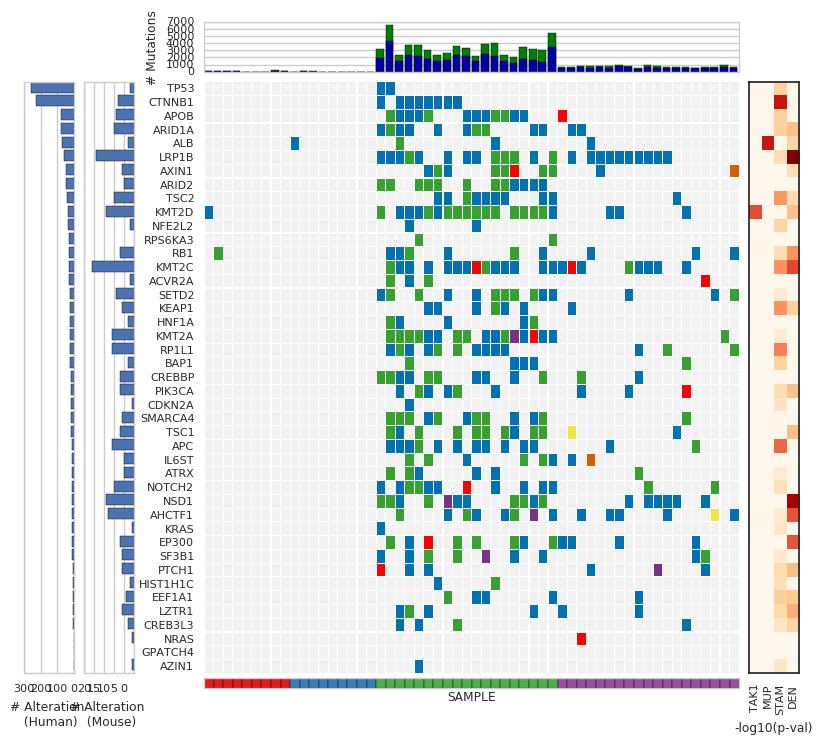

In [52]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(hcc_genes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'human')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt,'human_all.pdf')

In [21]:
! pwd

/cellar/users/mdow/Projects/HCC/Automate_figure_generate


48
Sub pval table: (14107, 5) (41, 5)
Sub count tables in human and mouse: (43, 3) (41, 3)
Sub main table: (56, 43)
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:77: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


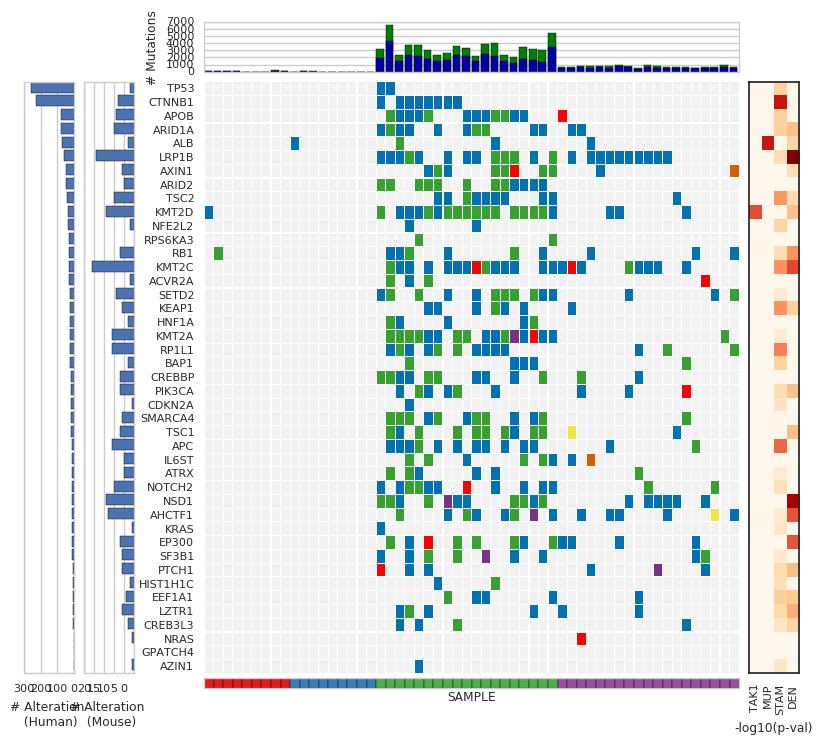

In [54]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(hcc_genes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'human')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'human_all.png')

In [55]:
'''
Take out non-recurrent synonymous genes
'''
tcga_genes = ['TP53','CTNNB1','ALB','AXIN1','BAP1','KEAP1','NFE2L2','LZTR1','RB1','PIK3CA',
              'RPS6KA3','AZIN1','KRAS','IL6ST','RP1L1','CDKN2A','EEF1A1','ARID2','ARID1A','GPATCH4',
             'ACVR2A','APOB','CREB3L3','NRAS','AHCTF1','HIST1H1C','SF3B1','SMARCA4']

icgc_genes = ['TP53','LRP1B','KMT2C','ARID1A','AXIN1','ARID2','TSC2','KMT2A','KMT2D','SETD2',
              'CREBBP','RB1','HNF1A','APC','ATRX','EP300','TSC1','NOTCH2','NSD1','PTCH1']

hcc_genes = tcga_genes + icgc_genes
#
# Recurrent if 
# Mutation has appeared in more than 3 sample at the same location

m1 = mouse.SYMBOL.isin(hcc_genes)
m2 = mouse.Consequence == 'synonymous_variant'
syn_hcc = mouse[(m1&m2)]#.Uploaded_variation.value_counts().reset_index()
synCnt = syn_hcc.groupby(['SYMBOL','Uploaded_variation']).SAMPLE.nunique().reset_index()
synCnt.columns = ['SYMBOL','Mutation','Count']

recurSyn = synCnt[synCnt.Count > 2]

recurSyn_genes = recurSyn.SYMBOL.unique()

recurSyn_genes

array(['ACVR2A', 'ARID2', 'KMT2A', 'SETD2', 'TSC1'], dtype=object)

In [56]:
recurSyn

,SYMBOL,Mutation,Count
0,ACVR2A,2_48893557_T/G,3
20,ARID2,15_96289117_C/T,7
22,ARID2,15_96370566_C/T,3
25,ARID2,15_96371886_T/C,3
76,KMT2A,9_44880888_T/G,4
154,SETD2,9_110550250_A/T,3
171,TSC1,2_28665582_C/T,3


In [57]:
tmp = mySorted.copy()
m1 = tmp == 1
m2 = ~tmp.columns.isin(recurSyn_genes)
m3 = tmp.index.str.contains('^J7')
tmp[(m1&m2)] = 0# = 0

In [58]:
# replace non-STAM back? 
tmp.iloc[~m3,:] = mySorted.iloc[~m3,:]

In [59]:
! pwd

/cellar/users/mdow/Projects/HCC/Automate_figure_generate


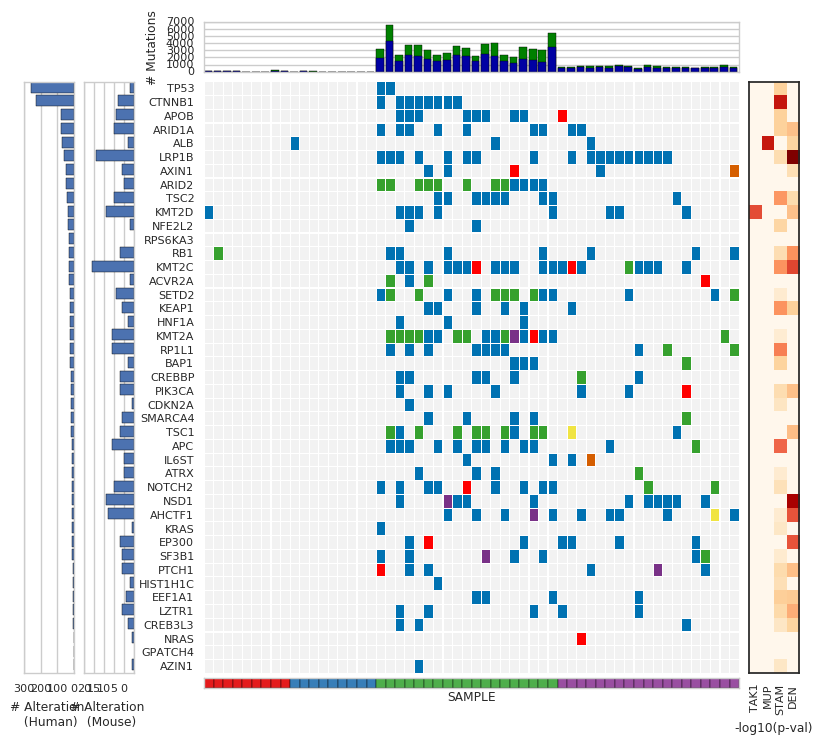

In [61]:
plot_final(tmp, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'human_recur.pdf')

## Cancer Consensus genes

In [29]:
# Check cosmic genes 

cosmicDir = '/cellar/users/mdow/Data/COSMIC/grch37/'
'''
Table of cancer genes information (HGNC)
'''
cosmicHGNC = pd.read_csv(cosmicDir+'CosmicHGNC.tsv',sep='\t')

print cosmicHGNC.shape

cosmicHGNC.columns = [u'COSMIC_ID', u'COSMIC_GENE_NAME', u'Entrez_id', u'HGNC_ID',
       u'mutated', u'Cancer_census', u'Expert_Curated']

print cosmicHGNC.Cancer_census.value_counts()


(561, 7)
y    559
n      2
Name: Cancer_census, dtype: int64


In [30]:
mouse_sig = pd.read_pickle('/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/Mouse_specific_freqMut_genes.pkl')

myGenes = mouse_sig.columns[~mouse_sig.columns.isin(cosmicHGNC.COSMIC_GENE_NAME)].tolist()

myGenes.remove('OBSCN')
myGenes.remove('VCAN')

In [31]:
print len(myGenes)

49


## Mouse significant genes

49
Sub pval table: (14107, 5) (49, 5)
Sub count tables in human and mouse: (47, 3) (49, 3)
Sub main table: (56, 49)
['MUC5B', 'FCGBP', 'DNAH1', 'DNAH10', 'COL7A1', 'MUC5AC', 'STAB1', 'PLCH1', 'MYH15', 'ATP1A3', 'RBBP6', 'AMBRA1', 'COL4A4', 'TAF1C', 'FASN', 'WDR11', 'ZNF48', 'RP1', 'MYH8', 'ZRANB3', 'FBXO41', 'DNHD1', 'NOL8', 'INPPL1', 'SSFA2', 'UFSP2', 'ZNF205', 'DLG1', 'GUSB', 'MBIP', 'AOC1', 'CASP1', 'PHF1', 'ESR2', 'EEF1D', 'ITGB4', 'RASIP1', 'ZBTB22', 'KHNYN', 'TBC1D15', 'TPH2', 'KRT1', 'RIPK2', 'EHHADH', 'EVA1A', 'FAM160B2', 'PLCXD2', 'HIST1H4K', 'CDCA8']
['MUC5B', 'FCGBP', 'DNAH1', 'DNAH10', 'COL7A1', 'MUC5AC', 'STAB1', 'PLCH1', 'MYH15', 'ATP1A3', 'RBBP6', 'AMBRA1', 'COL4A4', 'TAF1C', 'FASN', 'WDR11', 'ZNF48', 'RP1', 'MYH8', 'ZRANB3', 'FBXO41', 'DNHD1', 'NOL8', 'INPPL1', 'SSFA2', 'UFSP2', 'ZNF205', 'DLG1', 'GUSB', 'MBIP', 'AOC1', 'CASP1', 'PHF1', 'ESR2', 'EEF1D', 'ITGB4', 'RASIP1', 'ZBTB22', 'KHNYN', 'TBC1D15', 'TPH2', 'KRT1', 'RIPK2', 'EHHADH', 'EVA1A', 'FAM160B2', 'PLCXD2', 'HI

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


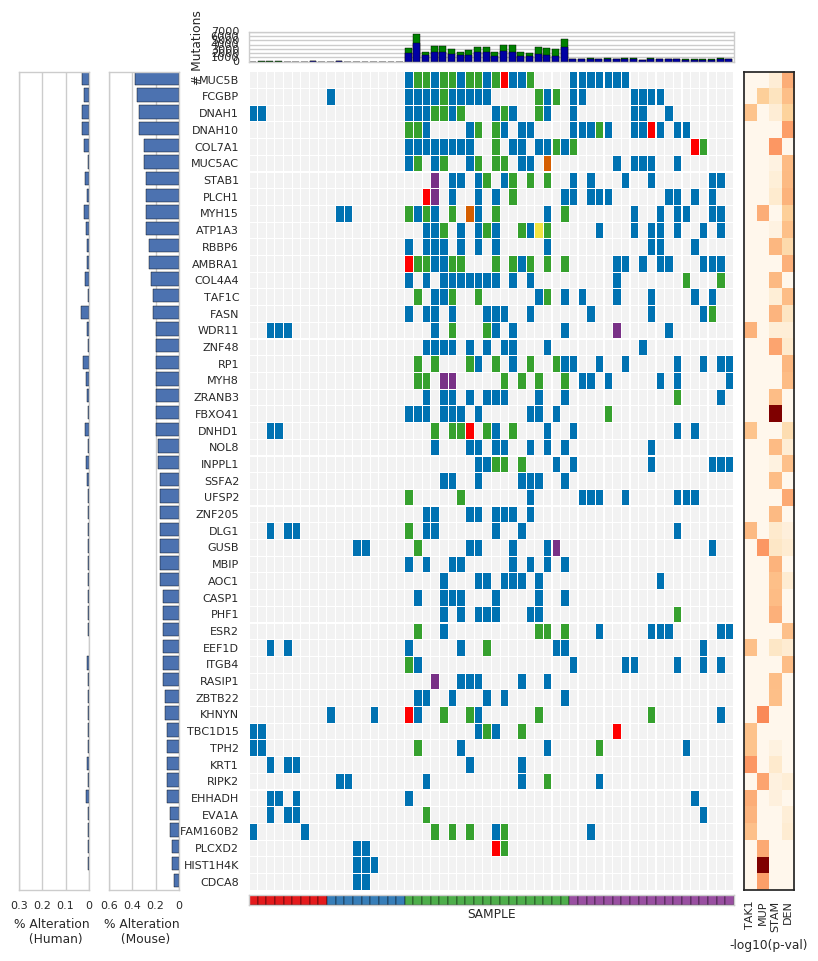

In [80]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(myGenes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final_small(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_sig.pdf')

## Mouse cancer genes (top 20 significant)

In [33]:
mouse_cancer = mouse_sig.columns[mouse_sig.columns.isin(cosmicHGNC.COSMIC_GENE_NAME)].tolist()

8
Sub pval table: (14107, 5) (8, 5)
Sub count tables in human and mouse: (7, 3) (8, 3)
Sub main table: (56, 8)
['BRAF', 'BRCA2', 'NSD1', 'NUTM1', 'RECQL4', 'SH2B3', 'MYC', 'GNAQ']
['BRAF', 'BRCA2', 'NSD1', 'NUTM1', 'RECQL4', 'SH2B3', 'MYC', 'GNAQ']


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


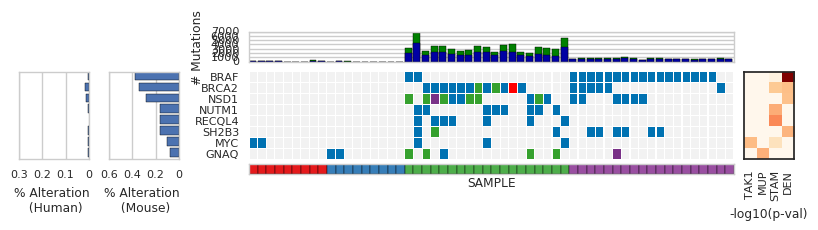

In [34]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(mouse_cancer, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final_small(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_cancer.pdf')

## Mouse cancer genes (top 20 significant + TERT)

9
Sub pval table: (14107, 5) (9, 5)
Sub count tables in human and mouse: (8, 3) (9, 3)
Sub main table: (56, 9)
['BRAF', 'BRCA2', 'NSD1', 'TERT', 'NUTM1', 'RECQL4', 'SH2B3', 'MYC', 'GNAQ']
['BRAF', 'BRCA2', 'NSD1', 'TERT', 'NUTM1', 'RECQL4', 'SH2B3', 'MYC', 'GNAQ']


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


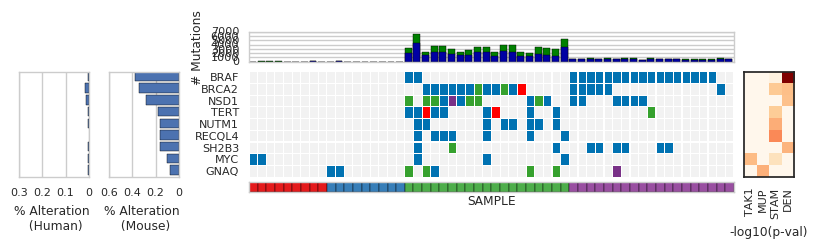

In [114]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(mouse_cancer+ ['TERT'], pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final_small(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_cancer.pdf')

In [115]:
! pwd

/cellar/users/mdow/Projects/HCC/Automate_figure_generate


## Mouse cancer genes (significant in one of the mouse)

In [76]:
cancer_genes = cosmicHGNC.COSMIC_GENE_NAME.tolist()

cancer_genes_l = [g.lower() for g in cancer_genes]

#pValDf.loc['tert',:]

sigGenes_all = pValDf[(pValDf < 0.05).any(axis=1)].Genes
sigGenes_cancer = sigGenes_all[sigGenes_all.isin(cancer_genes_l)]

75
Sub pval table: (14107, 5) (75, 5)
Sub count tables in human and mouse: (72, 3) (75, 3)
Sub main table: (56, 75)
['FAT4', 'KMT2C', 'LRP1B', 'RNF213', 'BRAF', 'UBR5', 'PTPRB', 'BRCA2', 'ATM', 'BCL9', 'KMT2D', 'NSD1', 'FAT1', 'COL1A1', 'ZFHX3', 'FANCD2', 'ARID1B', 'APC', 'PTPRK', 'SUZ12', 'TRRAP', 'SETBP1', 'TSC2', 'SPEN', 'NIN', 'PDGFRB', 'ARHGEF12', 'CNTRL', 'TERT', 'MN1', 'CIITA', 'SH2B3', 'PDGFRA', 'PCM1', 'NUTM1', 'RECQL4', 'NFATC2', 'RET', 'POLE', 'ABL1', 'CBL', 'ASXL1', 'CTNNB1', 'BCL9L', 'CAMTA1', 'BCOR', 'EP300', 'RB1', 'TSHR', 'PAX7', 'ARHGAP26', 'BCL11B', 'HOXA13', 'XPO1', 'KEAP1', 'GATA1', 'TP63', 'STRN', 'SS18L1', 'BUB1B', 'MYC', 'DNM2', 'FGFR1', 'FOXA1', 'OLIG2', 'HRAS', 'LMO2', 'NAB2', 'PTEN', 'PAX8', 'GNAQ', 'CANT1', 'FES', 'NPM1', 'APOBEC3B']
['FAT4', 'KMT2C', 'LRP1B', 'RNF213', 'BRAF', 'UBR5', 'PTPRB', 'BRCA2', 'ATM', 'BCL9', 'KMT2D', 'NSD1', 'FAT1', 'COL1A1', 'ZFHX3', 'FANCD2', 'ARID1B', 'APC', 'PTPRK', 'SUZ12', 'TRRAP', 'SETBP1', 'TSC2', 'SPEN', 'NIN', 'PDGFRB', 'A

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


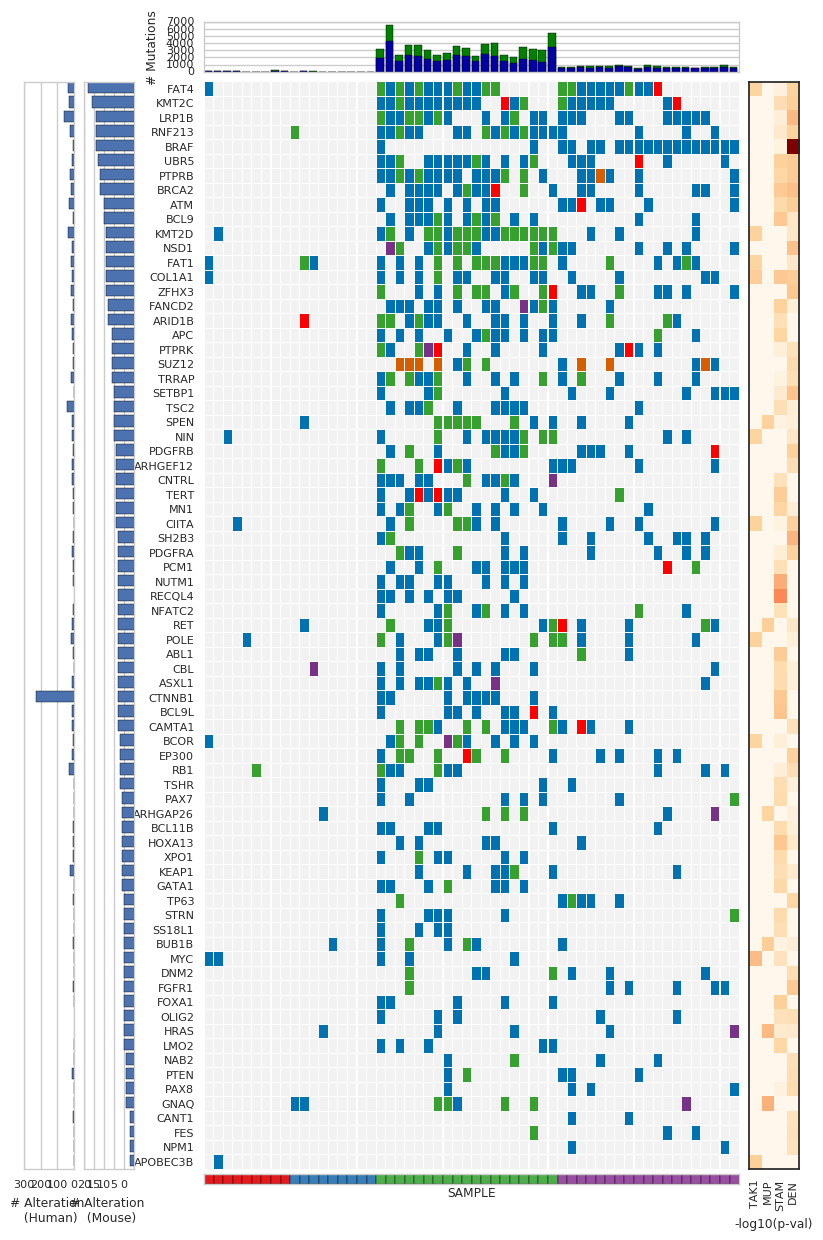

In [108]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(sigGenes_cancer, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_cancer_sig.pdf')

## Mouse cancer genes (all 500ish)

561
Sub pval table: (14107, 5) (482, 5)
Sub count tables in human and mouse: (514, 3) (460, 3)
Sub main table: (56, 556)
['FAT4', 'KMT2C', 'LRP1B', 'BRAF', 'RNF213', 'UBR5', 'PTPRB', 'BRCA2', 'ATM', 'CACNA1D', 'BCL9', 'FAT1', 'NSD1', 'COL1A1', 'ZFHX3', 'KMT2D', 'FANCD2', 'ARID1B', 'SUZ12', 'APC', 'TRRAP', 'PTPRK', 'KMT2A', 'AFF4', 'CIC', 'SETBP1', 'SPEN', 'TSC2', 'NIN', 'ARID1A', 'NOTCH2', 'PREX2', 'AFF1', 'SETD2', 'PDGFRB', 'FLT4', 'MN1', 'PTPRT', 'CIITA', 'CNTRL', 'TERT', 'TET1', 'COL2A1', 'ARHGEF12', 'NUP214', 'NCOR1', 'ERBB4', 'CTNNB1', 'CHD4', 'ABL1', 'SH2B3', 'NF1', 'PDGFRA', 'PDE4DIP', 'PCM1', 'NUTM1', 'NOTCH1', 'NFATC2', 'NCOR2', 'ROS1', 'NCOA1', 'MTOR', 'PTPN13', 'RECQL4', 'TOP1', 'RET', 'TNFAIP3', 'POLE', 'CBL', 'ALK', 'ASXL1', 'AXIN2', 'BCL9L', 'ATR', 'CARD11', 'CAMTA1', 'CREBBP', 'BCOR', 'MYO5A', 'MYH11', 'FGFR3', 'MUTYH', 'RB1', 'ERBB3', 'MSH2', 'EP300', 'LRIG3', 'MED12', 'DCTN1', 'TET2', 'FANCA', 'TSHR', 'TSC1', 'PML', 'FLT3', 'BLM', 'NUMA1', 'PIK3CA', 'KDM5A', 'BRCA1', '

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


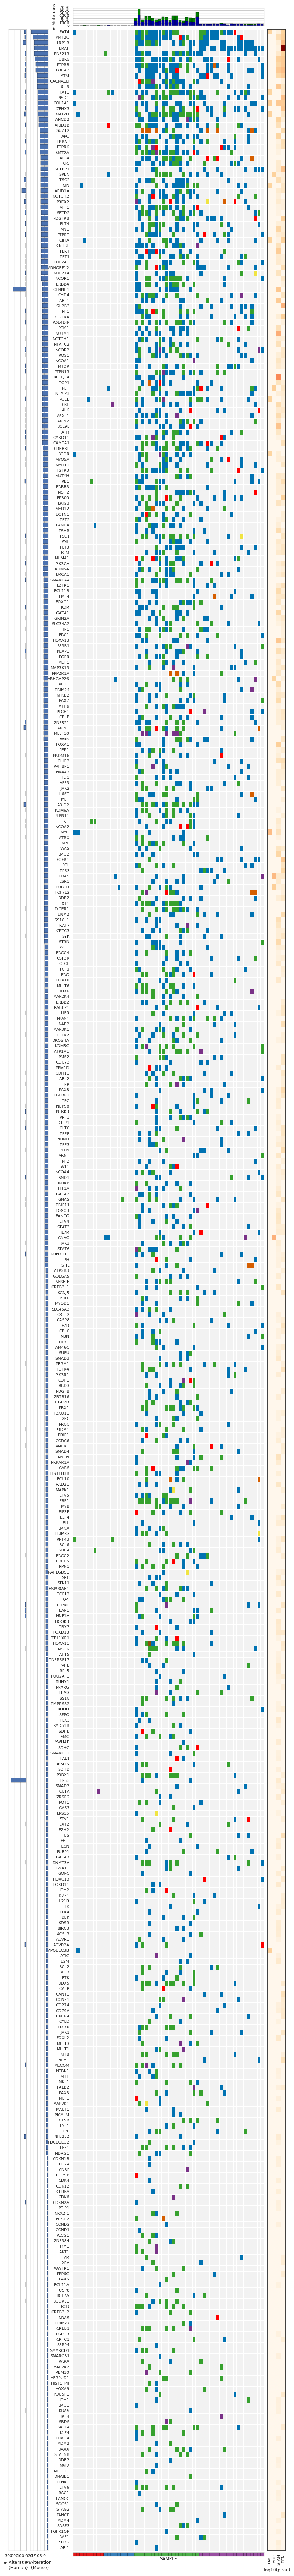

In [107]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(cancer_genes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_cancer_all.pdf')

## scratch

### Plot mouse significantly mutated genes

In [35]:
sigLs = get_sigGenes(pValDf, 0.05, 20)

DEN
False    13401
True       706
Name: DEN, dtype: int64
MUP
False    13951
True       156
Name: MUP, dtype: int64
STAM
False    13401
True       706
Name: STAM, dtype: int64
TAK1
False    13922
True       185
Name: TAK1, dtype: int64


In [36]:
#mouse_sub.iloc[:,mouse_sub.columns == 'HIST1H4K'] 

# TACC2 missense: AT136T1, AT136T2, AT136T3, AT863T1
# MUP HFD-13 is behaving weird, e.g. TMEM199
# MUP HIST1H4K: HFD-10, HFD1-T1, HFD1-T2

80
Sub pval table: (14107, 5) (79, 5)
Sub count tables in human and mouse: (72, 3) (78, 3)
Sub main table: (56, 78)
['HYDIN', 'OBSCN', 'UTRN', 'VCAN', 'LRP1B', 'BRAF', 'MUC5B', 'FCGBP', 'TACC2', 'DNAH10', 'BRCA2', 'PCDH15', 'COL7A1', 'MUC5AC', 'PLCH1', 'MYH15', 'STAB1', 'AMBRA1', 'RBBP6', 'LRBA', 'COL4A4', 'FASN', 'SLC44A5', 'TAF1C', 'RP1', 'FBXO41', 'MYH8', 'WDR11', 'ZNF48', 'ZRANB3', 'SLC9A2', 'NOL8', 'GUSB', 'AOC1', 'UFSP2', 'SSFA2', 'ZNF205', 'SH2B3', 'MBIP', 'RECQL4', 'HDLBP', 'DLG1', 'NUTM1', 'KDM4D', 'RASIP1', 'PHF1', 'CASP1', 'SPAG9', 'ITGB4', 'ZBTB22', 'DPYD', 'KHNYN', 'KRT1', 'WDR55', 'EHHADH', 'MYC', 'HRAS', 'RIPK2', 'PTPA', 'SEMA3A', 'GNAQ', 'EVA1A', 'IRX2', 'HAPLN4', 'NUDT12', 'PGK2', 'ETV2', 'PLCXD2', 'PCYOX1L', 'HIST1H4K', 'ABRA', 'CDCA8', 'TMEM199', 'OR6B1', 'VPS37D', 'TARBP2', 'SNCG', 'KRTDAP']
['HYDIN', 'OBSCN', 'UTRN', 'VCAN', 'LRP1B', 'BRAF', 'MUC5B', 'FCGBP', 'TACC2', 'DNAH10', 'BRCA2', 'PCDH15', 'COL7A1', 'MUC5AC', 'PLCH1', 'MYH15', 'STAB1', 'AMBRA1', 'RBBP6', 'LR

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


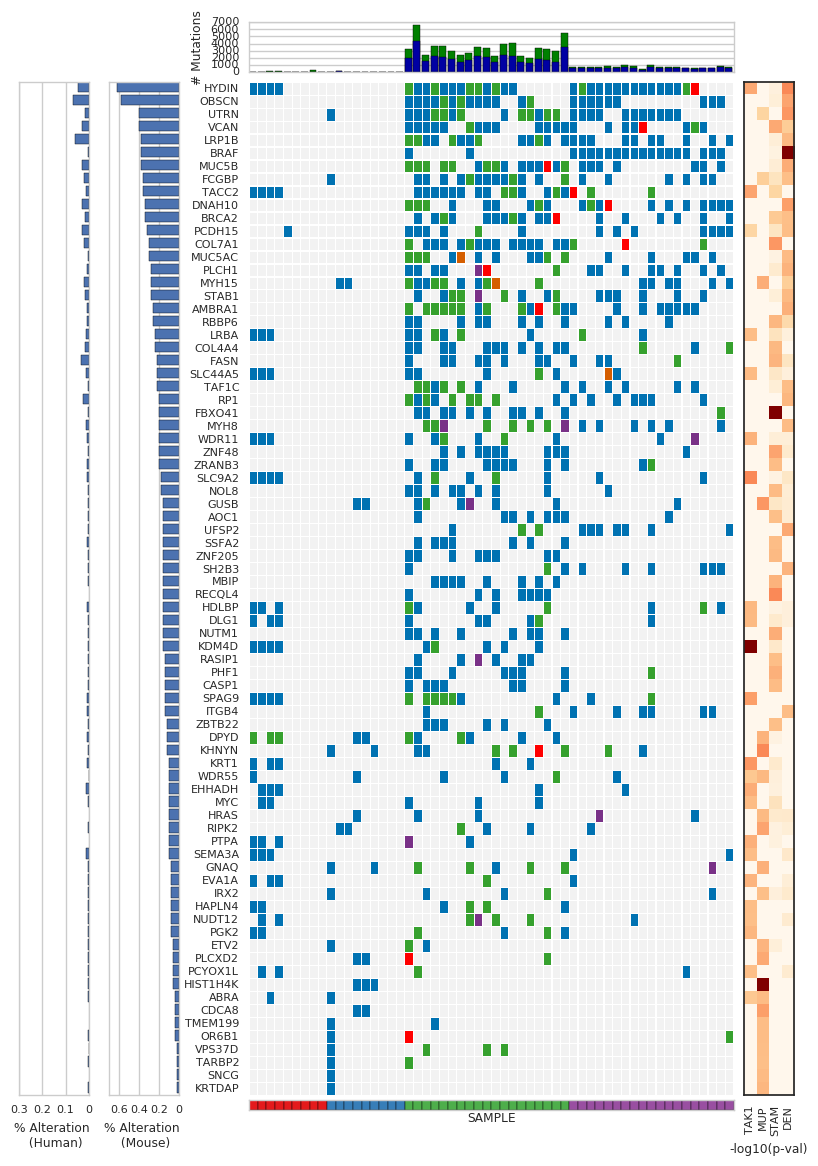

In [37]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(sigLs, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'test.png')

In [38]:
#tmp_srt = sort_comut(tmp,geneCnt_m_srt)
#plot_final(tmp_srt, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_noSyn.png')

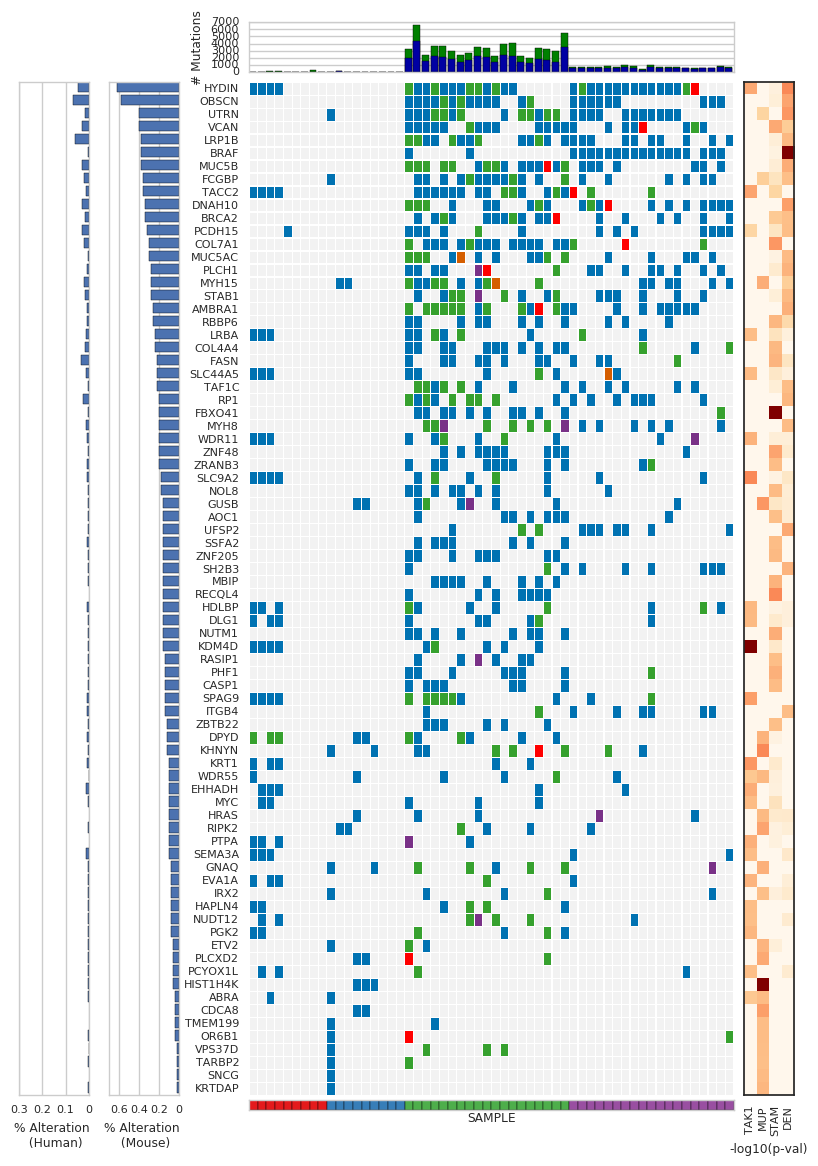

In [39]:
plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'human_all.png')

In [40]:
[i/float(56) for i in [0, 5, 10, 15,20,25]]

[0.0,
 0.08928571428571429,
 0.17857142857142858,
 0.26785714285714285,
 0.35714285714285715,
 0.44642857142857145]

In [41]:
[i/float(891) for i in [0,100,200,300]]

[0.0, 0.1122334455667789, 0.2244668911335578, 0.3367003367003367]

### Chunk

In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from argparse import ArgumentParser


## Functions
def get_sigGenes(pValDf, pThres, topN):
    sigLs = list()
    for i in pValDf.columns[0:4]:
        print i 
        print (pValDf.loc[:,i] < pThres).value_counts()
        sigGenes = pValDf.loc[:,i].sort_values()[0:topN].index
        [sigLs.append(g) for g in sigGenes]
        
    return sigLs

def subset_dfs(myGenes, pValDf, geneCnt_human, geneCnt_mouse, mouse_mutScore):
    myGenes_upper =[g.upper() for g in myGenes]
    myGenes_lower = [g.lower() for g in myGenes]

    # pVal df 
    pValDf_sub = pValDf[pValDf.Genes.isin(myGenes_lower+myGenes_upper)]
    pValDf_sub.index = [g.upper() for g in pValDf_sub.Genes]

    print len(myGenes)
    print 'Sub pval table:', pValDf.shape, pValDf_sub.shape

    # Gene alteration sample count table
    
    geneCnt_h_sub = geneCnt_human[geneCnt_human.SYMBOL.isin(myGenes_lower+myGenes_upper)]
    geneCnt_m_sub = geneCnt_mouse[geneCnt_mouse.SYMBOL.isin(myGenes_lower+myGenes_upper)]
    print 'Sub count tables in human and mouse:', geneCnt_h_sub.shape, geneCnt_m_sub.shape

    # Main score table
    mouse_sub = mouse_mutScore.iloc[:,mouse_mutScore.columns.isin(myGenes_lower+myGenes_upper)]
    print 'Sub main table:',mouse_sub.shape
    
    return pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub


'''
Determine the order of gene
Sorted by gene count, but the table can be either human or mouse
'''
def get_geneOrder(geneCnt):
    # Get gene order from gene counts 
    geneCnt_srt = geneCnt.sort_values('Count',ascending=False)
    geneCnt_srt['Count_r'] =geneCnt_srt.Count * -1
    geneOrder = geneCnt_srt.SYMBOL.tolist()
    
    return geneOrder

def sort_dfs(geneCnt_human, geneCnt_mouse,mouse_sub,pValDf_sub,species):
    
    if species == 'human':
        geneOrder = get_geneOrder(geneCnt_human)
    else:
        geneOrder = get_geneOrder(geneCnt_mouse)
    print geneOrder
    
    # Sort human gene count
    geneCnt_human.index = geneCnt_human.SYMBOL
    geneCnt_h_srt = geneCnt_human.loc[geneOrder,:]
    geneCnt_h_srt['Count_r'] =geneCnt_h_srt.Count * -1
    
    # Sort mouse gene count
    geneCnt_mouse.index = geneCnt_mouse.SYMBOL
    geneCnt_m_srt = geneCnt_mouse.loc[geneOrder,:]
    geneCnt_m_srt['Count_r'] =geneCnt_m_srt.Count * -1

    # Sort the heatmap by this gene list 
    mouse_sub_srt = mouse_sub.loc[:,geneOrder]

    '''
    Mouse model order
    '''
    
    # Sort p-value table
    pValDf_sub_srt = pValDf_sub.loc[geneOrder,model_order].fillna(1)
    
    return geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt


'''
sort samples and mutations like coMut waterfall
'''
def sort_comut(mouse_sub_srt, geneCnt_m_srt):
    #1. change to binary
    #2. sort by genes
    mouse_bi = mouse_sub_srt.copy()

    mouse_bi[mouse_bi > 1] = 1

    models = ['TAK1']*9 + ['MUP']*9 + ['STAM']*19 + ['DEN']*19 
    mouse_bi['models'] = models
    mouse_bi = mouse_bi.set_index([mouse_bi.models,mouse_bi.index])

    myGenes = geneCnt_m_srt.index.tolist()
    print myGenes
    mouse_sub_srtS = mouse_bi.sort_values(myGenes,ascending=False).T
    sample_sorted = mouse_sub_srtS.columns.tolist()

    # Get new order sorted by models
    sample_srtDf = pd.DataFrame(sample_sorted)
    sample_srtDf.columns = ['Model','Sample']
    tmp = sample_srtDf.groupby(['Model']).Sample.unique().reset_index()
    newOrder=list()
    for m in ['TAK1','MUP','STAM','DEN']:
        myList = tmp.Sample[tmp.Model == m].tolist()
        for s in myList[0]:
            #print s
            newOrder.append(s)

    mySorted = mouse_sub_srt.reindex(newOrder)
    return mySorted

def plot_final(heatmap_df, pval_df, top_count, left_count_human, left_count_mouse,figname):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    numGenes = heatmap_df.columns.nunique()

    sns.set(font_scale=0.8)
    plt.figure(figsize=(10,numGenes*0.2))
    ax = sns.heatmap(heatmap_df.T,cmap=myCmap,center=0,linewidths=0.1,cbar = 0)

    ax.set_xticklabels('')
    ax.set_ylabel('')

    # create new axes on the right and on the top of the current axes.
    divider = make_axes_locatable(ax)
    sns.set_style('whitegrid')
    axHistx = divider.append_axes("top", size=0.5, pad=0.1, sharex=ax) # Top 
    sns.set_style('white')
    axHisty = divider.append_axes("right", size=0.5, pad=0.1) #Right 
    sns.set_style('whitegrid')
    axHistz = divider.append_axes("bottom", size=0.1, pad=0.05, sharex=ax) # Bottom
    axHistk = divider.append_axes("left", size=0.5, pad=0.7, sharey=ax) # Left 1
    axHistk2 = divider.append_axes("left", size=0.5, pad=0.1, sharey=ax) # Left 2
    # the scatter plot:
    # histograms
    lim = 10
    binwidth=2
    bins = np.arange(-lim, lim + binwidth, binwidth)


    # Plot 1 - Right, total alterations -> P-value
    sns.set_style('white')
    myPvals_srt = pval_df
    axHisty.imshow(-np.log10(pval_df), cmap='OrRd', interpolation='nearest', aspect='auto')
    axHisty.yaxis.set_visible(False)
    axHisty.set_xticks([0,1,2,3])
    axHisty.set_xlabel("-log10(p-val)")
    axHisty.set_xticklabels(model_order,rotation=90)


    # Plot 2 - Top, Stack plot
    axHistx.bar(xrange(top_count.SAMPLE.nunique()),top_count.Total, color = "green")
    axHistx.bar(xrange(top_count.SAMPLE.nunique()),top_count.nonSyn_Count, color = "#0000A3")

    axHistx.xaxis.set_visible(False)
    axHistx.set_ylabel("# Mutations")

    # Plot 3 - plot on bottom, sample label
    axHistz.bar(xrange(top_count.SAMPLE.nunique()),[1]*top_count.SAMPLE.nunique(), color = modelColors,width=1)
    axHistz.xaxis.set_visible(False)
    axHistz.yaxis.set_visible(False)

    # Plot 4 - total alterations (Mouse)
    axHistk.barh(xrange(numGenes),left_count_mouse.Count_r)
    axHistk.yaxis.set_visible(False)
    xCntTicks = [20,15,10,5,0]
    xTicks = [float("{0:.2f}".format(i/float(56))) for i in xCntTicks]
    axHistk.set_xticklabels(xCntTicks)
    axHistk.set_xlabel("# Alteration \n (Mouse)")
    
    # Plot 5 - total alterations (Human)
    axHistk2.barh(xrange(numGenes),left_count_human.Count_r)
    axHistk2.yaxis.set_visible(False)
    axHistk2.set_xticks([-300,-200,-100,0])
    axHistk2.set_xticklabels([300,200,100,0])
    axHistk2.set_xlabel("# Alteration \n (Human)")
    
    ax.figure.savefig(figname)

'''
Load the variant effect definitions 
'''

import var_def

syn = var_def.syn
missense = var_def.missense
splice = var_def.splice
nonsense = var_def.nonsense
frameshift = var_def.frameshift
inframeIndel = var_def.inframeIndel
silentRegions = var_def.silentRegions
others = var_def.others

'''
Model colours
'''
colors = sns.color_palette("Set1", 4)
modelColors=((colors[0],) * 9 +(colors[1],) * 9 + (colors[2],) * 19 +(colors[3],) * 19)

'''
coMut plot colors
'''
brown=sns.color_palette("BrBG", 10)[0]
purple=sns.color_palette("PRGn", 8)[0]
colorLs=sns.color_palette("colorblind", 8)
#blue=sns.color_palette("deep", 10)[0]
blue=sns.color_palette("colorblind", 10)[0]
green = sns.color_palette("Paired", 10)[3]
orange=colorLs[2]
yellow=colorLs[4]

myCmap = mpl.colors.ListedColormap([brown,"#f2f2f2",yellow,orange,"#f2f2f2",green,purple,'r',blue])
model_order = ['TAK1','MUP','STAM','DEN']


def main(geneSet,sortSpecies,figname):

	'''
	Load data
	'''
	mouse = pd.read_pickle('mouse_mut_final.pkl')
	human = pd.read_pickle('human_mut_final.pkl')
	print mouse.shape, human.shape

	unstackDf = pd.read_pickle('mutation_score_table_combo.pkl')
	mouse_mutScore = unstackDf[~unstackDf.index.str.contains('DO')]
	print unstackDf.shape, mouse_mutScore.shape

	pValDf = pd.read_pickle('gene_rank_pVal.pkl')
	print pValDf.shape

	'''
	Load gene set
	'''
	tmp = pd.read_csv(geneSet,header=None)
	tmp.columns = ['Gene']
	myGenes = tmp.Gene.tolist()

	'''
	Process
	'''
	subCols = ['MODEL','SAMPLE','SYMBOL','Consequence','Species']
	combo = pd.concat([mouse[subCols],human[subCols]])
	nonSyn_ls = missense + nonsense + splice + frameshift + inframeIndel
	combo['nonSyn'] = combo.Consequence.isin(nonSyn_ls)

	'''
	Count gene alteration
	'''
	mask_h = combo.Species == 'Human'
	mask_m = combo.Species == 'Mouse'
	m1= combo.nonSyn == True

	geneCnt_h = combo[(mask_h&m1)].groupby(['SYMBOL']).SAMPLE.nunique().reset_index(name='Count')
	geneCnt_m = combo[(mask_m&m1)].groupby(['SYMBOL']).SAMPLE.nunique().reset_index(name='Count')

	numH = combo[(mask_h&m1)].SAMPLE.nunique()
	numM = combo[(mask_m&m1)].SAMPLE.nunique()
	geneCnt_m ['Pct'] =geneCnt_m.Count/float(numM)
	geneCnt_h ['Pct'] =geneCnt_h.Count/float(numH)

	geneCnt_h.head()

	'''
	Count total mutations
	'''
	# For stack plot - need the total (green) and the non-syn (blue)
	mutCnt = combo[(mask_m&m1)].groupby(['SAMPLE']).nonSyn.value_counts().reset_index(name='nonSyn_Count')
	mutCnt_total= mouse[mouse.Consequence.isin(syn+nonSyn_ls)].groupby('SAMPLE').Uploaded_variation.nunique().reset_index(name='Total')
	mutCnt_all = pd.merge(mutCnt,mutCnt_total)

	'''
	Main script
	'''
	pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(myGenes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)
	geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,sortSpecies)
	mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)
	plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt,figname)


if __name__ == "__main__":
    parser = ArgumentParser()
    parser.add_argument('--geneSet', dest='geneSet', type=str, default='tcga_hcc_genes.txt', required=False, help='Calculaate correlation by specific gene set') 
    parser.add_argument('--sortSpecies', dest='sortSpecies',type=str, default='mouse', required=False, help='Sort the genes by which species? Type mouse or human')
    parser.add_argument('--figname', dest='figname',type=str, default='mutation_genes_landscape.png', required=False, help='Name of the final figure')

    args = parser.parse_args()

    main(args.geneSet,args.sortSpecies,args.figname)

usage: __main__.py [-h] [--geneSet GENESET] [--sortSpecies SORTSPECIES]
                   [--figname FIGNAME]
__main__.py: error: unrecognized arguments: -f /run/user/887/jupyter/kernel-ad68a695-caba-4847-a9d2-aae10d4eb5b7.json


SystemExit: 2

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
